# Import

In [1]:
# Spliceai2022 environment
import pandas as pd
import matplotlib.pyplot as plt
import pysam
import seaborn as sns
from pyliftover import LiftOver
from matplotlib_venn import venn2

In [2]:
# Define the parameters used to create the plots
rc = {'figure.figsize':(7,7),
      'axes.facecolor':'white',
      'figure.facecolor':'white',
      'axes.grid' : False,
      'font.size' : 20,    
      'font.sans-serif': 'Arial',
      'font.family': 'sans-serif',
      'svg.fonttype' : 'none'}


# (A) Comparison to GTEx dataset

In [3]:
def convert_to_hg38(file):

    # Function to convert coordinates
    def convert_coordinate(chr, coord):
        converted = []
        converted_coord = lo.convert_coordinate(chr, coord)
        if converted_coord:
            return converted_coord[0][1]
        else:
            return 'NA'
    # Read your file into a DataFrame
    df = pd.read_csv(file,
                    sep='\t',
                    header=None,
                    names=['Gene', 'Paralog', 'Chr', 'Strand', 'TxStart', 'TxEnd', 'hg19ESS', 'hg19EES'])

    # Create a LiftOver object for hg19 to hg38 conversion
    lo = LiftOver('hg19', 'hg38')
        
    for index, row in df.iterrows():
        chr = row['Chr']
        df.at[index, 'TxStart38'] = convert_coordinate(chr, row['TxStart'])
        df.at[index, 'TxEnd38'] = convert_coordinate(chr, row['TxEnd'])
        ESS38 = []
        for coord in row['hg19ESS'].split(',')[:-1]:
            ESS38.append(convert_coordinate(chr, int(coord)))
        ESS38 = ','.join(map(str, ESS38))
        EES38 = []
        for coord in row['hg19EES'].split(',')[:-1]:
            EES38.append(convert_coordinate(chr, int(coord)))
        EES38 = ','.join(map(str, EES38))
        df.at[index, 'hg38ESS'] = ESS38
        df.at[index, 'hg38EES'] = EES38

    df['Chr'] = df['Chr'].str.replace('chr', '')

    return df

# Convert gtex from hg19 to hg38
gtex = convert_to_hg38('../datasets/gtex_dataset.txt')

retina = pd.read_csv('../datasets/retina503.15samples.txt',
                    sep='\t',
                    header=None,
                    names=['Gene', 'Paralog', 'Chr', 'Strand', 'TxStart', 'TxEnd', 'ESS', 'EES'])

In [4]:
# Create a set for TxStart, TxEnt, ESS and EES
def populate_sets_from_dataframe(dataframe, txstart_col, txend_col, ess_col, ees_col):
    txstart_set = set()
    txend_set = set()
    ess_set = set()
    ees_set = set()

    for index, row in dataframe.iterrows():
        txstart_set.add(str(row['Gene'] + ':' + row['Chr']) + ':' + row['Strand'] + ':' + str(row[txstart_col]))
        txend_set.add(str(row['Gene'] + ':' + row['Chr']) + ':' + row['Strand'] + ':' + str(row[txend_col]))

        ess = row[ess_col].rstrip(',').split(',')
        for i in ess:
            ess_set.add(str(row['Gene'] + ':' + row['Chr']) + ':' + row['Strand'] + ':' + str(i))
        ees = row[ees_col].rstrip(',').split(',')
        for i in ees:
            ees_set.add(str(row['Gene'] + ':' + row['Chr']) + ':'+ row['Strand'] + ':' + str(i))

    return txstart_set, txend_set, ess_set, ees_set

retina_txstart, retina_tx_end, retina_ess, retina_ees = populate_sets_from_dataframe(
    retina, 'TxStart', 'TxEnd', 'ESS', 'EES')

gtex_txstart, gtex_tx_end, gtex_ess, gtex_ees = populate_sets_from_dataframe(
    gtex, 'TxStart38', 'TxEnd38', 'hg38ESS', 'hg38EES')

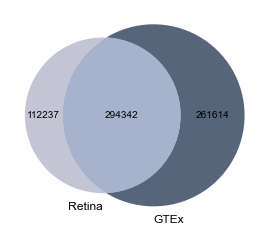

In [5]:

retina_ss = retina_ess.union(retina_ees)
gtex_ss = gtex_ess.union(gtex_ees)

plt.rcParams.update(rc)

# Create a Venn diagram
venn2(subsets=(len(retina_ss - gtex_ss), len(gtex_ss - retina_ss), len(retina_ss & gtex_ss)),
      set_labels=('Retina', 'GTEx'), set_colors=('#AAADC4', '#102542'), alpha = 0.7)

# Display the diagram
plt.savefig('Trainingdata_overlapwithgtex.svg',  bbox_inches='tight', dpi = 300)
plt.show()


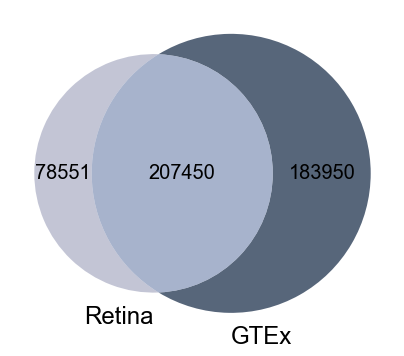

In [6]:
# Create the same plot for splice junction on the training chromosomes
train_chr = ['2', '4', '6', '8', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y']

retina_train = retina[retina['Chr'].isin(train_chr)]
gtex_train = gtex[gtex['Chr'].isin(train_chr)]

retina_txstart_train, retina_tx_end_train, retina_ess_train, retina_ees_train = populate_sets_from_dataframe(
    retina_train, 'TxStart', 'TxEnd', 'ESS', 'EES')

gtex_txstart_train, gtex_tx_end_train, gtex_ess_train, gtex_ees_train = populate_sets_from_dataframe(
    gtex_train, 'TxStart38', 'TxEnd38', 'hg38ESS', 'hg38EES')


retina_ss_train = retina_ess_train.union(retina_ees_train)
gtex_ss_train = gtex_ess_train.union(gtex_ees_train)

plt.rcParams.update(rc)

# Create a Venn diagram
venn2(subsets=(len(retina_ss_train - gtex_ss_train), len(gtex_ss_train - retina_ss_train), len(retina_ss_train & gtex_ss_train)),
      set_labels=('Retina', 'GTEx'), set_colors=('#AAADC4', '#102542'), alpha = 0.7)

# Display the diagram
plt.savefig('Trainingdata_overlapwithgtex_trainchr.svg',  bbox_inches='tight', dpi = 300)
plt.show()

# Check how many retinas-specific exons are in each dataset

In [7]:
# To do: Keep SAS and SDS separate

# load the exons
retina_exons = pd.read_csv('../ref_data/retina_enriched_exons.bed', sep = '\t')
retina_exons = retina_exons.values.tolist()
print('Number of retina-specific exons: ', len(retina_exons))

exon_sas = []
exon_sds = []

for i in retina_exons:
    chr = i[0][3:]
    if i[3] == 1:
        strand = '+'
    else:
        strand = '-'
    if strand == '+':
        exon_sas.append(str(chr) + ':' + strand + ':' + str(i[1]))
        exon_sds.append(str(chr) + ':' + strand + ':' + str(i[2]))
    else:
        exon_sds.append(str(chr) + ':' + strand + ':' + str(i[1]))
        exon_sas.append(str(chr) + ':' + strand + ':' + str(i[2]))

exon_sas = set(exon_sas)
exon_sds = set(exon_sds)

# Remove gene from retina and gtex junctions
retina_sas = set([':'.join(i.split(':')[1:]) for i in retina_ess])
retina_sds = set([':'.join(i.split(':')[1:]) for i in retina_ees])
gtex_sas = set([':'.join(i.split(':')[1:]) for i in gtex_ess])
gtex_sds = set([':'.join(i.split(':')[1:]) for i in gtex_ees])

Number of retina-specific exons:  197


In [8]:
print('Retina SAS not in retina data: ', len(exon_sas - retina_sas))
print('Retina SDS not in retina data: ', len(exon_sds - retina_sds))

print('GTEx SAS not in retina data: ', len(exon_sas - gtex_sas))
print('GTEx SDS not in retina data: ', len(exon_sds - gtex_sds))

print('Retina SAS not in both datasets: ', len(exon_sas - (retina_sas | gtex_sas)))
print('Retina SDS not in both datasets: ', len(exon_sds - (retina_sds | gtex_sds)))


Retina SAS not in retina data:  126
Retina SDS not in retina data:  118
GTEx SAS not in retina data:  135
GTEx SDS not in retina data:  124
Retina SAS not in both datasets:  115
Retina SDS not in both datasets:  107


In [9]:
sas = []

for i in exon_sas - (retina_sas | gtex_sas):
    individual = i.split(':')
    sas.append([individual[0], individual[1], individual[2]])

sds = []

for i in exon_sds - (retina_sds | gtex_sds):
    individual = i.split(':')
    sds.append([individual[0], individual[1], individual[2]])

sas_df = pd.DataFrame(sas)
sds_df = pd.DataFrame(sds)
sas_df.to_csv('../ref_data/sas_not_in_train.tsv', sep = '\t', index  = None)
sds_df.to_csv('../ref_data/sds_not_in_train.tsv', sep = '\t', index = None)

# PacBio junctions not in training data

In [25]:
acceptors = pd.read_csv('../ref_data/pacbio_novel_acceptors.tsv', sep = '\t', header = None)
donors = pd.read_csv('../ref_data/pacbio_novel_donors.tsv', sep = '\t', header = None)

retina_sas_nostrand = set([':'.join([i.split(':')[1], i.split(':')[3]]) for i in retina_ess])
retina_sds_nostrand = set([':'.join([i.split(':')[1], i.split(':')[3]]) for i in retina_ees])
gtex_sas_nostrand = set([':'.join([i.split(':')[1], i.split(':')[3]]) for i in gtex_ess])
gtex_sds_nostrand = set([':'.join([i.split(':')[1], i.split(':')[3]]) for i in gtex_ees])

pacbio_sas = []
for index, row in acceptors.iterrows():
    pacbio_sas.append(str(row[0][3:]) + ':' + str(row[1]))

pacbio_sds = []
for index, row in donors.iterrows():
    pacbio_sds.append(str(row[0][3:]) + ':' + str(row[1]))

pacbio_sas = set(pacbio_sas)
pacbio_sds = set(pacbio_sds)

In [26]:
print('Retina SAS not in retina data: ', len(pacbio_sas - retina_sas_nostrand))
print('Retina SDS not in retina data: ', len(pacbio_sds - retina_sds_nostrand))

print('GTEx SAS not in retina data: ', len(pacbio_sas - gtex_sas_nostrand))
print('GTEx SDS not in retina data: ', len(pacbio_sds - gtex_sds_nostrand))

print('Retina SAS not in both datasets: ', len(pacbio_sas - (retina_sas_nostrand | gtex_sas_nostrand)))
print('Retina SDS not in both datasets: ', len(pacbio_sds - (retina_sds_nostrand | gtex_sds_nostrand)))


Retina SAS not in retina data:  10691
Retina SDS not in retina data:  11142
GTEx SAS not in retina data:  10846
GTEx SDS not in retina data:  11354
Retina SAS not in both datasets:  10576
Retina SDS not in both datasets:  11031


In [28]:
sas = []

for i in pacbio_sas - (retina_sas_nostrand | gtex_sas_nostrand):
    individual = i.split(':')
    sas.append([individual[0], individual[1]])

sds = []

for i in pacbio_sds - (retina_sds_nostrand | gtex_sds_nostrand):
    individual = i.split(':')
    sds.append([individual[0], individual[1]])

sas_df = pd.DataFrame(sas)
sds_df = pd.DataFrame(sds)
sas_df.to_csv('../ref_data/pacbio_sas_not_in_train.tsv', sep = '\t', index  = None)
sds_df.to_csv('../ref_data/pacbio_sds_not_in_train.tsv', sep = '\t', index = None)

# (B) Splice junction motif